# Data Management

This lab shifts your focus from the model to the data itself, tackling the common challenges of real-world datasets. You'll be working with the **[Oxford 102 Flowers](https://www.robots.ox.ac.uk/~vgg/data/flowers/102/) dataset**, a collection of images and labels that are stored in separate files, with inconsistent formatting, and possibly even some corrupted samples. To overcome these hurdles, you will use PyTorch's core data management tools: The **`Dataset`** and **`DataLoader`** classes.

In this lab, you will:

* Explore a real-world dataset with unorganized files and separated labels.
* Build a custom PyTorch **`Dataset`** to load and preprocess images and labels on-the-fly.
* Apply **transformations** and **data augmentation** to prepare your data and improve model robustness.
* Use the **`DataLoader`** to efficiently create and shuffle batches for training.
* Split your data into training, validation, and test sets.
* Implement error-handling techniques to manage data issues and monitor your pipeline’s performance.

In [57]:
import os
import tarfile
import matplotlib.pyplot as plt 
import numpy as np 
import requests
import scipy
from PIL import Image
from torch.utils.data import Dataset, Subset, random_split, DataLoader
from torchvision import transforms
from tqdm.auto import tqdm

import helper


## Data Access

Every deep learning project starts with data, but not all data is ready to use.  
Sometimes it’s already well organized, but often it’s scattered or stored in formats that aren’t directly compatible with model training.
In this section, you’ll learn how to manage data access and follow best practices for working with unorganized or inconsistent datasets.

### Dataset Exploration


The first step when working with a new dataset is to access and explore its structure.
This helps you understand how the data is organized, and therefore, how to load and use it effectively.

* You will define a  `download_dataset` function that downloads the dataset from a given URL and extracts it to a specified directory.
* In this case, the dataset consists of two files: a `.tgz`  file with images and a `.mat` file containing the labels.

Both files will be downloaded using the `requests` library and then extracted using the `tarfile` library.

In [58]:
def download_dataset():
    """
    Downloads and extracts a dataset from remote URLs if not already present locally.

    This function first checks for the existence of the dataset files in a specific
    directory. If the files are not found, it proceeds to download them from
    pre-defined URLs, showing progress bars, and then extracts the contents.
    """

    #Define the directory to store the dataset
    data_dir = "flower_data"

    #Define paths for key files and folders
    image_folder_path = os.path.join(data_dir, "jpg")
    labels_file_path = os.path.join(data_dir, "imagelabels.mat")
    tgz_path = os.path.join(data_dir, "102flowers.tgz")

    #Check if key label file already exist
    if os.path.exists(image_folder_path) and os.path.exists(labels_file_path):
        print(f"Dataset already exist, loading locally '{data_dir}'")
        return
    
    print("Dataset not found locally. Downloading...")

    # Define the URLs for the image archive and the labels file.
    image_url = "https://www.robots.ox.ac.uk/~vgg/data/flowers/102/102flowers.tgz"
    labels_url = "https://www.robots.ox.ac.uk/~vgg/data/flowers/102/imagelabels.mat"

    #Create the target directory if it's not exist
    os.makedirs(data_dir, exist_ok=True)

    print("Downloading images...")

    #Http request to get image
    response = requests.get(image_url, stream=True)
    
    #Get the totle size of the file from the response header
    total_size = int(response.headers.get("content-length", 0))

    #Open a local file in binary write mode to save the downloaded archive
    with open(tgz_path, "wb") as file:
        #Iterate over the response content in chunk with a progress bar
        for data in tqdm(
            #Define the chunk sie for iterating ove the content
            response.iter_content(chunk_size=1024),
            total = total_size // 1024,
        ):
            
            #Write each chunk of data to the file
            file.write(data)

    print("Extracing files...")

    #Open the downloaded tar,gz archive in read mode
    with tarfile.open(tgz_path, "r:gz") as tar:
        #Extract all contents of the archive inot the target directory
        tar.extractall(data_dir)

    print("Downloading labels...")

    response = requests.get(labels_url)
    with open(labels_file_path, "wb") as file:
        #Write the entire content of the response to the file
        file.write(response.content)

    print(f"Dataset downloaded and extracted to '{data_dir}'")

    #Crete labels_description.txt
    # create labels_description.txt
    labels_description = [
        'pink primrose', 'hard-leaved pocket orchid', 'canterbury bells', 'sweet pea', 'english marigold', 'tiger lily',
        'moon orchid', 'bird of paradise', 'monkshood', 'globe thistle', 'snapdragon', "colt's foot", 'king protea',
        'spear thistle', 'yellow iris', 'globe-flower', 'purple coneflower', 'peruvian lily', 'balloon flower',
        'giant white arum lily', 'fire lily', 'pincushion flower', 'fritillary', 'red ginger', 'grape hyacinth',
        'corn poppy', 'prince of wales feathers', 'stemless gentian', 'artichoke', 'sweet william', 'carnation',
        'garden phlox', 'love in the mist', 'mexican aster', 'alpine sea holly', 'ruby-lipped cattleya', 'cape flower',
        'great masterwort', 'siam tulip', 'lenten rose', 'barbeton daisy', 'daffodil', 'sword lily', 'poinsettia',
        'bolero deep blue', 'wallflower', 'marigold', 'buttercup', 'oxeye daisy', 'common dandelion', 'petunia',
        'wild pansy', 'primula', 'sunflower', 'pelargonium', 'bishop of llandaff', 'gaura', 'geranium', 'orange dahlia',
        'pink-yellow dahlia?', 'cautleya spicata', 'japanese anemone', 'black-eyed susan', 'silverbush', 'californian poppy',
        'osteospermum', 'spring crocus', 'bearded iris', 'windflower', 'tree poppy', 'gazania', 'azalea', 'water lily',
        'rose', 'thorn apple', 'morning glory', 'passion flower', 'lotus', 'toad lily', 'anthurium', 'frangipani',
        'clematis', 'hibiscus', 'columbine', 'desert-rose', 'tree mallow', 'magnolia', 'cyclamen ', 'watercress',
        'canna lily', 'hippeastrum ', 'bee balm', 'ball moss', 'foxglove', 'bougainvillea', 'camellia', 'mallow',
        'mexican petunia', 'bromelia', 'blanket flower', 'trumpet creeper', 'blackberry lily'
    ]

    with open(os.path.join(data_dir, "label_description.txt"), "w") as f:
        for idx, label in enumerate(labels_description, start=1):
            f.write(f"{label}\n")



In [59]:
download_dataset()

Dataset already exist, loading locally 'flower_data'


In [60]:
#Define the path to he root directory of dataset
path_dataset = './flower_data'

#Display the folder strucure of the dataset directory up to a depth of one
helper.print_data_folder_structure(path_dataset, max_depth=1)

flower_data/
├── 102flowers.tgz
├── imagelabels.mat
├── jpg/
└── label_description.txt


### Creating a Custom Dataset Class

Having downloaded and briefly explored the dataset, the next step is to create a custom dataset class that organizes access to the data. The goal is to retrieve images and their corresponding labels consistently and efficiently for model training.

You will create a class `FlowerDataset` that inherits from `torch.utils.data.Dataset`.
A custom dataset class *must* implement the following methods:

> `__init__`: Initializes the dataset object.
> * Typically accepts the data path and any transforms to apply.
> * Optionally loads metadata or labels associated with the data.

> `__len__`: Returns the number of samples in the dataset.

> `__getitem__`: Retrieves a single sample given an index.
> * Loads the image and its label, applies transforms, and returns them.

Additionally, you will define helper methods to make the code cleaner and more organized:

> `load_and_correct_labels`: Loads image labels from the MATLAB .mat file.
> * It uses `scipy.io.loadmat` to read the file and extract the labels array.
> * The labels are adjusted by subtracting 1, which is necessary because MATLAB uses 1-based indexing, while Python uses 0-based indexing. 
>    * This correction prevents off-by-one errors during training and evaluation.

> `retrieve_image`: Loads an image from disk given its index `idx`. 
> * Given `idx`, it constructs the filename and path, opens the image using the Pillow library, converts it to RGB format (to ensure consistency), and returns the image object.

> `get_label_description`: Given a label, returns a human-readable description from the text file.

**Regarding lazy loading**:
The images are not loaded all at once when the dataset object is created.
Instead, they are loaded on-the-fly when accessed via the `__getitem__` method.
This approach is memory efficient, especially when dealing with large datasets, as it avoids loading all images into memory at once.

In [61]:
class FlowerDataset(Dataset):
    """
    A custom dataset class for loading flower image data.

    This class is designed to work with PyTorch's Dataset and DataLoader
    abstractions. It handles loading images and their corresponding labels
    from a specific directory structure.
    """

    def __init__(self, root_dir, transforms=None):
        """
        Initializes the dataset object
        Args:
            root_dir(str): The root directory where the dataset is stored.
            transfor(callable, optional): Optional transform to be applied on a sample
        """
        self.root_dir = root_dir
        self.transform = transforms
        self.image_dir = os.path.join(self.root_dir, "jpg")
        #Load and process the label from the correspoding file.
        self.labels = self.load_and_correct_labels()

    def __len__(self):
        """
        Returns the total number of sample in the dataset.
        """
        return len(self.labels)
    
    def __getitem__(self, index):
        """
        Retrieves a sample from the dataset at the specified index.

        Args:
            idx (int): The index of the sample to retrieve.

        Returns:
            tuple: A tuple containing the image and its label.
        """
        #Retrive the image for the given folder
        image = self.retrieve_image(index)

        #Chckif a tranfom is provided
        if self.transform is not None:
            #Apply the tranform to theimage
            image = self.transform(image)

        #Get the label correspoding to the index
        label = self.labels[index]

        return image, label
    
    def retrieve_image(self, idx):
        """
        Load a single image from the disk based on it's index
        Args:
            idx(int):Index of the image to load
            
        returns:
            PIL.Image.Image: Loaded image converted to RGB
        """

        #Construct the image filename based on the index (e.g. 'image_oooo1.jpg')
        img_name = f"image_{idx+1:05d}.jpg"
        #Construct the full path to the image file
        img_path = os.path.join(self.image_dir, img_name)

        #Open the. image file
        with Image.open(img_path) as img:
            #Conver the image to the RGB color space and return it
            image = img.convert("RGB")
        return image

    def load_and_correct_labels(self):
        """
        Load labels from the .mat file and adjust them to be zero indexed.

        Returns:
            numpy.ndarray: An array of zero indexed integer labels.
        """
        # Load the MATLAB file containing the labels
        self.labels_mat = scipy.io.loadmat(
            os.path.join(self.root_dir, "imagelabels.mat")
        )

        # Extract labels and convert to zero-based indexing
        labels = self.labels_mat["labels"][0] - 1

        return labels

    def get_label_description(self, label):
        """
        Retrieves the text description for a given label index.

        Args:
            label (int): The integer label.

        Returns:
            str: The corresponding text description of the label.
        """

        #Path to the file containing label descriptions.
        path_lables_descriptions = os.path.join(self.root_dir, "label_description.txt")

        #Open the label description file for reading
        with open(path_lables_descriptions, "r") as f:
            #Read line from the file
            lines = f.readlines()
        
        description = lines[label].strip()
        return description

In [62]:
# Initialize the dataset object, providing the path to the data.
dataset = FlowerDataset(path_dataset)
print(f"Number of sample in the dataset: {len(dataset)}")

Number of sample in the dataset: 8189


* Retrieve a specific sample using an index. and inspect the image size and label

In [63]:
sel_idx = 10
img, label = dataset[sel_idx]

image_size_info = f"Image size {img.size}"
print(f"{image_size_info}, Label: {label}")

Image size (500, 748), Label: 76


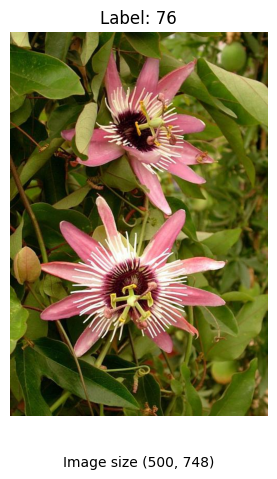

In [64]:
# Visualze the image using the helper function

helper.plot_img(img, label=label, info=image_size_info)

In [65]:
#Inspect the labels in dataset

#Get all the labels from the dataset object
dataset_labels = dataset.labels

#Create aset of unique label to. remove duplicate
unique_labels = set(dataset_labels)

#Iterte through each unique label
for label in unique_labels:
    print(f"Label{label}, Description:{dataset.get_label_description(label)}")

Label0, Description:pink primrose
Label1, Description:hard-leaved pocket orchid
Label2, Description:canterbury bells
Label3, Description:sweet pea
Label4, Description:english marigold
Label5, Description:tiger lily
Label6, Description:moon orchid
Label7, Description:bird of paradise
Label8, Description:monkshood
Label9, Description:globe thistle
Label10, Description:snapdragon
Label11, Description:colt's foot
Label12, Description:king protea
Label13, Description:spear thistle
Label14, Description:yellow iris
Label15, Description:globe-flower
Label16, Description:purple coneflower
Label17, Description:peruvian lily
Label18, Description:balloon flower
Label19, Description:giant white arum lily
Label20, Description:fire lily
Label21, Description:pincushion flower
Label22, Description:fritillary
Label23, Description:red ginger
Label24, Description:grape hyacinth
Label25, Description:corn poppy
Label26, Description:prince of wales feathers
Label27, Description:stemless gentian
Label28, Desc

### Overview of the Images in the Dataset


Now that you have a working dataset class, you can explore the images in the dataset. You will make use of the `visual_exploration` function to visualize a few images to get a better understanding of the data.

In [ ]:
def visual_exploration(dataset, num_rows=2, num_cols=4):
    """
    Displays a grid of randomly selected samples from a dataset for visual inspection.

    Args:
        dataset: The dataset object from which to draw samples. It should support
                 indexing and have a `get_label_description` method.
        num_rows (int): The number of rows in the display grid.
        num_cols (int): The number of columns in the display grid.
    """

    #Calculate the total number of images to display in the grid
    total_samples = num_rows * num_cols

    #Select a random set of unique indices from the dataset
    indices = np.random.choice(len(dataset), total_samples, replace=False)

    #Create a grid of subplots to hold the images
    fig, axes = helper.get_grid(num_rows, num_cols, figsize=(num_cols*3, num_rows*4))

    #Iterate over each. subplot axi and the correspoding random sample index
    for ax, idx in zip(axes.flatten(), indices):
        #Retrive the image and numberican labels from dataset
        image, label = dataset[idx]

        #Get the text description
        description = dataset.get_label_description(label)

        #Format a new label string that include both the number and description.
        label = f"{label} - {description}"

        #Create an information stringwiththe sample's index and image dimensions.
        info = f"Index: {idx} Size: {image.size}"

        #plot the image on the current subplot with it's lable and info
        helper.plot_img(image,label=label, info=info, ax=ax)

    plt.show()

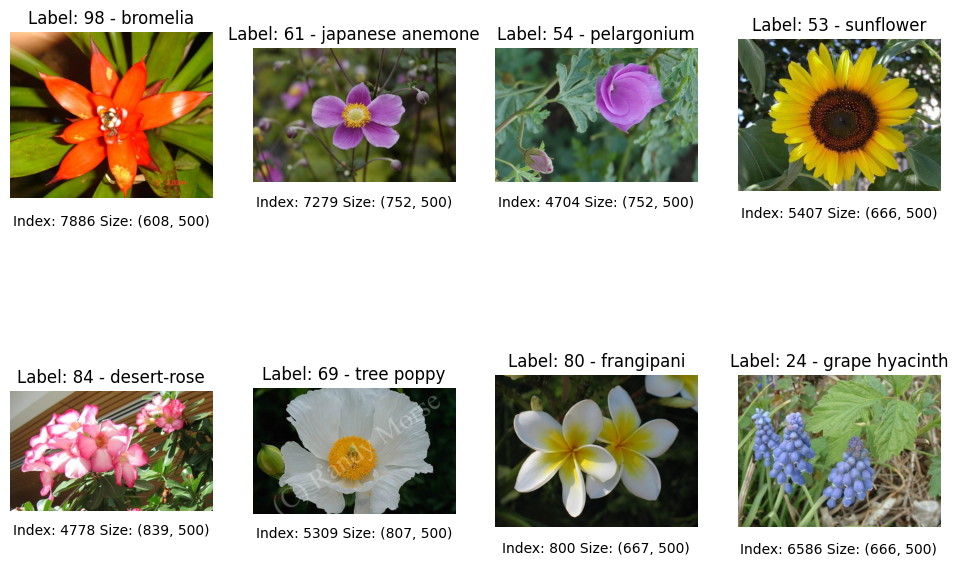

In [68]:
#Display a 2X4 grid of random samples from the dataset for visual inspection
visual_exploration(dataset, num_rows=2, num_cols=4)

## Quality Problems

As you have seen in the previous section, the size of the images in the dataset varies significantly. This can be a problem when training a model, as most models expect input images to have the same size. To address this issue, you will implement a series of transformations to standardize the size of the images.

### Transformations

After exploring the dataset and identifying potential quality issues, the next step is to apply transformations to preprocess the images.
Transformations are operations that modify images to prepare them for model training. Common examples include resizing, cropping, flipping, and normalizing pixel values.
The `torchvision.transforms` module provides a variety of pre-defined transformations that can be easily applied to images.

You’ll start by defining a simple transformation pipeline composed of two stages:

Transformations **applied directly to the raw images**:
- `Resize((256, 256))`: Resizes each image to a fixed size of 256×256 pixels.
- `CenterCrop(224)`: Crops the center of the image to 224×224 pixels.

Transformations that **convert and standardize images**:
- `ToTensor()`: converts a PIL Image or NumPy array to a tensor and scales pixel values to the range [0, 1].
- `Normalize(mean, std)`: normalizes the tensor using the specified mean and standard deviation.

**Note**: 
The order of transformations often matters. Resizing and cropping should be applied before converting the image to a tensor.

In [69]:
#Define the mean value for normalization
mean = [0.485, 0.456, 0.406]
# Define the standard deviation values for normalization.
std = [0.229, 0.224, 0.225]

In [70]:
transform = transforms.Compose([
    #Image transorm
    transforms.Resize((256, 256)),
    transforms.CenterCrop(224),

    #bridge to tensor
    transforms.ToTensor(),
    transforms.Normalize(mean=mean, std=std)
])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.622571].


Shape: torch.Size([3, 224, 224])
Type: torch.float32
Range of pixel values: [-2.1, 2.6]


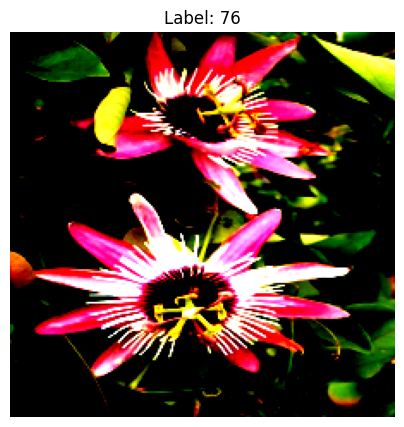

In [71]:
#Create  new dataset instance with the specified image transformations
dataset_transformed = FlowerDataset(path_dataset, transforms=transform)

#Retrieve the transofrmed image and it's label 
img_transformed, label = dataset_transformed[sel_idx]

#Quick check 
helper.quick_debug(img_transformed)

#Plot the transofmed image 
helper.plot_img(img_transformed, label=label)

Observe that the image is now a tensor with shape `[3, 224, 224]` representing 3 color channels (RGB) and 224×224 pixels.
Because the pixel values have been normalized, they are no longer in the original range of [0, 255].

That’s why the image looks different when visualized directly.
To display it correctly, you need to *denormalize* it first. You can do this by applying the `Normalize` transformation again, using `new_mean` and `new_std` values to reverse the normalization process.

In [ ]:
class Denormalize:
    """
    A callable class to reverse the normalization of a tensor image.

    This class calculates the inverse transformation of a standard normalization
    and can be used as a transform step, for instance, to visualize images
    after they have been normalized for a model.
    """

    def __init__(self, mean, str):
        """
        Initializes the denormalization transform.

        Args:
            mean (list or tuple): The mean values used for the original normalization.
            std (list or tuple): The standard deviation values used for the original
                                 normalization.

        Normalize formula =>x(norm) = (x-m)/s
        Denormalize formula => x = x(norm)* s + m
        """
        #Calculate the adjusted mean for the denormaliation process
        new_mean = [-m/s for m,s in zip(mean, std)]

        #Calculate the adjusted standard deviation for the denormalization process
        new_std = [1/s for s in std]

        #Create a normalize transformobject with the inverse parameters
        self.denormalize = transforms.Normalize(mean=new_mean, std=new_std)

    def __call__(self, tensor):
        """
        Applies the denormalization transform to a tensor.

        Args:
            tensor: The normalized tensor to be denormalized.

        Returns:
            The denormalized tensor.
        """

        return self.denormalize(tensor)

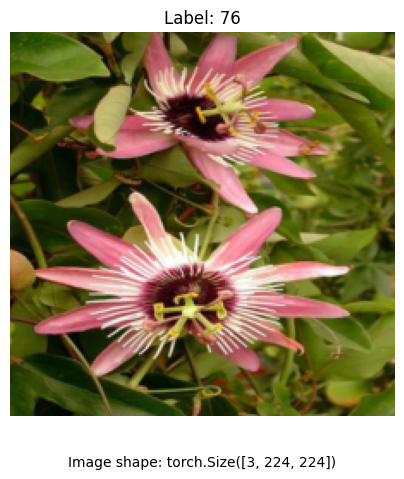

In [73]:
denormalize = Denormalize(mean=mean, str=std)

#Apply the denormalization tranform to the image tensor
img_tensor = denormalize(img_transformed)

img_shape_info = f"Image shape: {img_tensor.size()}"

helper.plot_img(img_tensor, label=label, info=img_shape_info)

## Data Loading


In this section, you’ll learn how to prepare and serve data efficiently for model training in PyTorch.
A full training process typically includes three stages: training, validation, and evaluation.

During training, the model learns from the training data by adjusting its weights based on the loss function. 
During validation, the model is evaluated on a separate dataset to tune hyperparameters and prevent overfitting.
During evaluation, the model’s performance is tested on unseen data to assess its generalization ability.

Each of these stages requires splitting the dataset into distinct subsets and using data loaders to feed data efficiently during training and testing. In what follows, you will see how to do this using PyTorch.

### Splitting the Dataset

The `split_dataset` function will divide the dataset into training, validation, and test sets.
To do this, you will:

* Define the sizes of each subset from the given fractions for validation and test,
* Make use of `random_split` from `torch.utils.data` to perform the actual split.

In [76]:
def split_dataset(dataset, val_fraction=0.15, test_fraction=0.15):
    """
    Split the dataset into training , validation and test sets
    By default this function split the data into 70% for traning 15% for validation and 15% fortesting
    """

    #Calculate the size of each split
    total_size = len(dataset)
    val_size = int(total_size * val_fraction)
    test_size = int(total_size* test_fraction)
    train_size = total_size-val_size-test_size

    #Use random split to create the dataset
    train_dataset, val_dataset, test_dataset = random_split(
        dataset, [train_size, val_size, test_size]
    )

    return train_dataset, val_dataset, test_dataset

In [77]:
train_dataset, val_dataset, test_dataset = split_dataset(dataset_transformed)
print(f"Length of training dataset:   {len(train_dataset)}")
print(f"Length of validation dataset: {len(val_dataset)}")
print(f"Length of test dataset:       {len(test_dataset)}")

Length of training dataset:   5733
Length of validation dataset: 1228
Length of test dataset:       1228


### Dataloaders

Once your dataset is split into training, validation, and test sets, the next step is to serve data efficiently to your model during training and evaluation. 
PyTorch’s `DataLoader` class handles this by batching samples, shuffling data during training, and simplifying iteration over your dataset.
Using dataloaders helps speed up training and ensures your model sees a diverse mix of samples in each batch.
Now you will create dataloaders for each subset of the data (training, validation, and test).
You will use the `DataLoader` class from `torch.utils.data` to create dataloaders.
The arguments you will provide include:
- `dataset`: The dataset to load data from (e.g., `train_dataset`, `val_dataset`, `test_dataset`),
- `batch_size`: The number of samples per batch to load (e.g., `32`),
- `shuffle`: Whether to shuffle the data at every epoch (typically `True` for training and `False` for validation and test).

In [78]:
#Set batch size
batch_size = 32

#Create the DataLoader for training set data
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

To understand how dataloaders work, you can iterate for two epochs over the training and validation dataloaders and, at the very end, iterate over the test dataloader.
This will give you a sense of how data is served in batches during training and evaluation.

In [ ]:
#Define the total number of traning epochs
n_epochs = 2

for epoch in range(n_epochs):
    print(f"Processing epoch {epoch}===")
    print(f"Pass number {epoch} through the training set")
    print("Traning...")

    #Get the total number of sample in the traning set
    train_sample = len(train_dataset)

    #Create a progress bar for the traning data loader 
    train_bar = helper.get_dataloader_bar(train_dataloader, color='blue')

    #Iterate over the training data loader to get batches of images and labels
    for batch, (image, labels) in enumerate(train_dataloader):
        #update the training progress bar for the curret batch
        helper.update_dataloader_bar(train_bar, batch, batch_size, train_sample)

    print(f"Pass number {epoch} through the validation set")
    print("validation...")

    #Create a progress bar for the validation data loader
    val_bar = helper.get_dataloader_bar(val_dataloader, color='red')
    #Get te total number of sample in the validation set
    val_sample = len(val_dataset)

    #Iterate over the validation data loader to get the batch iamges and labels
    for batch, (images, labels) in enumerate(val_dataloader):
    #Update the validation progress bar for the current batch
        helper.update_dataloader_bar(val_bar, batch, batch_size, val_sample)

In [ ]:
#Final evaluation on the test daataset
print("Final pass through the test set for evaluation")

test_bar = helper.get_dataloader_bar(test_dataloader, color='green')

#Get the totalnumber. of sample on the test set
test_samples = len(test_dataset)

#Iterate over the test data loader to get the batches of image and label
for batch, (image, label) in enumerate(test_dataloader):
    helper.update_dataloader_bar(test_bar, batch, batch_size, test_samples)

## Augmentation


Data augmentation is an important technique for improving the robustness and generalization of deep learning models.
By applying random transformations, such as flipping, rotating, or adjusting brightness, to training images, augmentation helps models recognize objects under varied real-world conditions. 

In PyTorch, augmentation can be performed "on-the-fly," generating endless image variations without extra storage. 

Within `get_augmentation_transform`, you’ll create a more advanced transformation pipeline that includes data augmentation techniques.
This pipeline consists of the following:

Transformations that augment the raw images:
- `RandomHorizontalFlip(p=0.5)`: This transformation randomly flips the image horizontally with a probability of 0.5,
- `RandomRotation(degrees=10)`: This transformation randomly rotates the image within a range of -10 to +10 degrees,
- `ColorJitter(brightness=0.2)`: This transformation randomly changes the brightness, contrast, saturation, and hue of the image.

Transformations that standardize the images as `transform`: `Resize`, `CenterCrop`, `ToTensor`, and `Normalize`.

You then create a new instance of the `FlowerDataset` class, this time passing the augmentation transformation pipeline `augmentation_transform` as an argument.

In [83]:
def get_augmentation_transform(mean, std):
    """
    Creates and returns a composition of image transformations for data augmentation
    and preprocessing.

    Args:
        mean (list or tuple): A sequence of mean values for each channel.
        std (list or tuple): A sequence of standard deviation values for each channel.

    Returns:
        torchvision.transforms.Compose: A composed pipeline of transformations.
    """

    #Define a list of data augmentation transformations to be applied randomly
    augmentation_transforms = [
        #Randomly flip the image horizontally with a 50% probability
        transforms.RandomHorizontalFlip(p=0.5),
        #Randomly rorate the image within a range from +- -10 degree
        transforms.RandomRotation(degrees=10),
        #Randomly adjust the brightness of the image
        transforms.ColorJitter(brightness=0.2),
    ]

    #Define the mail list of standard, non-ramdom tranformations.
    main_tranforms = [
        #Resize the input image 256X256 pixels
        transforms.Resize((256, 256)),
        #Crop the center 224X224 pixel of the image
        transforms.CenterCrop(224),

        #Conver the PIL image to PyTorch tensor
        transforms.ToTensor(),
        #Normalize the tensor with the provided mean and standard deviation
        transforms.Normalize(mean=mean, std=std)
    ]

    #Combine the augmentaion and main transormation into a single pipline
    tranform = transforms.Compose(augmentation_transforms+ main_tranforms)
    return tranform

In [84]:
#Create the augmentation and preprocessing pipeline providing the normalization stats
augmentation_transform = get_augmentation_transform(mean=mean, std=std)

#Initialize a new dataset instance that will use the augmentation pipeline
dataset_augmented = FlowerDataset(path_dataset, transforms=augmentation_transform)

Debugging a dataset pipeline is a relevant step to ensure that the transformations and data loading processes are functioning as intended.
`visualize_augmentation` allows you to visualize the effect of the augmentation transformations on a sample image. 

For a given number of versions, it retrieves the same sample image from the dataset. As the dataset applies random transformations, each retrieved version of the image will be affected differently, allowing you to see the variety of augmentations applied.

In [85]:
def visualize_augmentations(dataset_aug, idx=0, num_versions=8):
    """
    Displays multiple augmented versions of a single image from a dataset.

    This function repeatedly retrieves an image from a dataset with augmentations
    enabled, then displays each unique, randomly generated version in a grid
    to help visualize the effect of the transformations.

    Args:
        dataset_aug: The dataset object with augmentation transforms applied.
        idx (int): The index of the image in the dataset to visualize.
        num_versions (int): The total number of augmented versions to display.
    """

    #Create a denormalization transorm to revert normalization for display
    denormalize = Denormalize(mean, std)

    #Set the numner of rows for the visualization grid
    n_rows = 2
    #Caculate the number of columns needed based on the total versions to show
    n_cols = num_versions // n_rows

    #Create a grid of subplot to display iamge
    fig, axes = helper.get_grid(n_rows, n_cols, figsize=(16, 8))

    #Iterate through each subplot axis in the grid
    for ax in axes.flatten():
        #Get a new, randomly augmented version of the same image by index
        img, label = dataset_aug[idx]

        #Denormalize the iamge tensor so it can be dispplayed correctly
        img = denormalize(img)

        #Plot the augmented image on the current subplot
        helper.plot_img(img=img, ax=ax)

    plt.show()

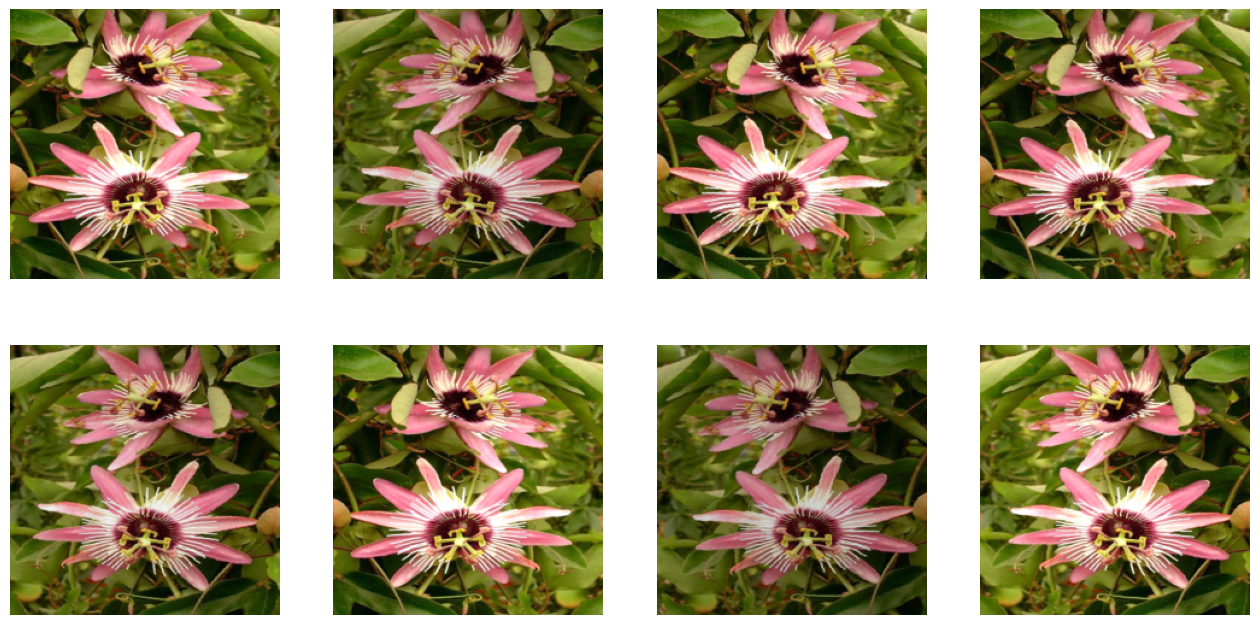

In [87]:
visualize_augmentations(dataset_augmented,idx=sel_idx, num_versions=8)

### Splitting with Augmentation

Integrating proper random splitting with data augmentation requires careful handling to ensure that the training, validation, and test sets are distinct and that augmentation is applied only to the training data.

One subtle point to consider is that when using `random_split`, each of the splits is a `Subset` object that references the original dataset.
Therefore those subsets will inherit the transformations defined in the original dataset and can not be assigned different transformations directly.

To address this, you will create a custom dataset class `SubsetWithTransform` that wraps around a `Subset` and allows you to specify a different transformation for it.

In [88]:
class SubsetWithTransform(Dataset):
    """
    A wrapper for a PyTorch Subset that applies a specific transformation.

    This class allows for applying a different set of transformations to a
    subset of a dataset, which is useful for creating distinct training,
    validation, or test sets with different preprocessing steps from the
    same base dataset.
    """

    def __init__(self, subset, transform=None):
        """
        Initializes the SubsetWithTransform object.

        Args:
            subset: A PyTorch Subset object containing a portion of a dataset.
            transform (callable, optional): An optional transform to be applied
                to the samples within this subset.
        """
        #Store the original subset of the dataset
        self.subset = subset
        #Store the transformations to be applied
        self.transform = transform

    def __len__(self):
        """
        Return the total number of samples in the subset

        """
        return len(self.subset)
    
    def __getitem__(self, idx):
        """
        Retrieves a sample and applies the transform.

        Args:
            idx (int): The index of the sample to retrieve.

        Returns:
            tuple: A tuple containing the transformed image and its label.
        """

        #Get the original image and label for the underlying subset
        image, label = self.subset[idx]

        #Check if transfrom has been provided
        if self.transform:
            image = self.transform(image)

        return image, label

In [89]:
#Apply the augmentation pipleine to the traning subset 
train_dataset = SubsetWithTransform(train_dataset, transform=augmentation_transform)
#Apply the basic preprocessing transform to the validation dataset
val_dataset = SubsetWithTransform(val_dataset, transform=transform)
#Apply the basic preprocessing transform to the test dataset
test_dataset = SubsetWithTransform(test_dataset, transform=transform)

In [90]:
#check that indeed the training dataset has the augmentation transformations applied, while the validation and test datasets do not.
print(train_dataset.transform)
print(val_dataset.transform)
print(test_dataset.transform)


Compose(
    RandomHorizontalFlip(p=0.5)
    RandomRotation(degrees=[-10.0, 10.0], interpolation=nearest, expand=False, fill=0)
    ColorJitter(brightness=(0.8, 1.2), contrast=None, saturation=None, hue=None)
    Resize(size=(256, 256), interpolation=bilinear, max_size=None, antialias=True)
    CenterCrop(size=(224, 224))
    ToTensor()
    Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
)
Compose(
    Resize(size=(256, 256), interpolation=bilinear, max_size=None, antialias=True)
    CenterCrop(size=(224, 224))
    ToTensor()
    Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
)
Compose(
    Resize(size=(256, 256), interpolation=bilinear, max_size=None, antialias=True)
    CenterCrop(size=(224, 224))
    ToTensor()
    Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
)


### Error Handling


You will create a new custom dataset class `RobustFlowerDataset` that extends the original `FlowerDataset` class to handle potential issues with corrupted or problematic images.

The `__init__`, `__len__` and `load_and_correct_labels` methods remain mostly the same as in the original `FlowerDataset` class.

The main differences are:

> `__getitem__`: Implements a try-except block to catch exceptions that may occur when loading an image.
> * If an exception occurs (e.g., due to a corrupted image file), the code will print and log the error by calling the `log_error` method. 
> * It then attempts to retrieve the next image in the dataset instead of stopping execution.

> `retrieve_image`: Handles the actual image loading process. 
> * Constructs the filename and path, verifies image integrity using Pillow’s `verify()` method, and reloads the image to ensure it is fully loaded into memory.
> * Checks the image size, raising an error if it’s smaller than 32 pixels in either dimension, and converts grayscale images to RGB for consistency.

> `get_error_summary`: Provides a summary of all errors encountered during data loading, useful for debugging and assessing dataset quality.

In [93]:
class RobustFlowerDataset(Dataset):
    """
    A custom dataset class with robust error handling for loading images.

    This class is designed to gracefully handle issues with individual data
    samples, such as corrupted files or incorrect formats. It logs any errors
    and attempts to load a different sample instead of crashing.
    """

    def __init__(self, root_dir, transform=None):
        """
        Initializes the dataset object.

        Args:
            root_dir (str): The root directory where the dataset is stored.
            transform (callable, optional): Optional transform to be applied
                on a sample.
        """
        #Store the root directory path
        self.root_dir = root_dir
        #Construct the full path to the image directory
        self.img_dir = os.path.join(root_dir, "jpg")

        #Store the optional transformations
        self.transform = transform
        #Load and process the labels from the corresponding file
        self.labels = self.load_and_correct_labels()
        #Initialize a list to keep tranck of any errors encountered
        self.error_log=[]

    def __getitem__(self, idx):
        """
        Retrieves a sample, handling errors by trying the next available item.

        Args:
            idx (int): The index of the sample to retrieve.

        Returns:
            tuple: A tuple containing the image and its label.
        """

        #Loop to attempt loading a valid sample, preventing an infinite loop
        for attempt in range(len(self)):
            #Attempt to load and process the sample
            try:
                #Retrieve the image using the helper method
                image = self.retrieve_image(idx)
                #Check if a transform has been provided
                if self.transform:
                    #Apply the transfrom to the image
                    image = self.transform
                #Get the label for the currecnt index
                label = self.labels[idx]
                return image, label
            except Exception as e:
                self.log_error(idx, e)
                #Move to the next index, wrapping around if neccessary
                idx = (idx+1) % len(self)

    def __len__(self):
        """
        Returns the total number of samples in the dataset.
        """
        return len(self.labels)
    
    def retrieve_image(self, idx):
        """
        Loads and validates a single image from disk.

        Args:
            idx (int): The index of the image to load.

        Returns:
            PIL.Image.Image: The validated and loaded image object.
        """

        #Construct the image filename based on the index
        img_name = f"image_{idx+1:05d}.jpg"
        #Construct the full path to the image file
        img_path = os.path.join(self.img_dir, img_name)
        #Open the image fileto check it's integrity without loading fully
        with Image.open(img_path) as img:
            #Perfom a quick varification of the file's structure
            img.verify()

        #Re-open the image file after succesful varification
        image = Image.open(img_path)
        #Fully load the image data in memory
        image.load()
        #check if the image dimentions are below a minimum threashold
        if image.size[0] < 32 or image.size[1] <32:
            #Raise an error for image that are too small
            raise ValueError(f"Image too small: {image.size}")
        
        #Check if image is not in RGB color
        if image.mode != "RGB":
            #Conver tht image to RGB
            image = image.convert("RGB")
        return image
    

    def load_and_correct_labels(self):
        """
        Loads labels from a .mat file and adjusts them.

        Returns:
            numpy.ndarray: An array of zero-indexed integer labels.
        """

        #Load the matlab file containing the labels
        self.labels_mat = scipy.io.loadmat(
            os.path.join(self.root_dir, "imagelabels.mat")
        )

        #Extract the labels array and correct for zero-based. indexing
        labels = self.labels_mat["labels"][0]-1
        #Truncate the dataset to the first 10 lables for quick testing
        labels = labels[:10]
        #Retur the processed labels
        return labels
    
    def log_error(self, idx, e):
        """
        Records the details of an error encountered during data loading.

        Args:
            idx (int): The index of the problematic sample.
            e (Exception): The exception object that was raised.
        """

        #Constuct the filename of the problematic image
        img_name = f"image_{idx+1:05d}.jpg"
        img_path = os.path.join(self.img_dir, img_name)

        #Append a dictonary with error details to the log
        self.error_log.append(
            {
                "index": idx,
                "error": str(e),
                "path": img_path if "img_path" in locals() else "unknow",
            }
        )

        print(f"Warning: Skipping corrupted image {idx}: {e}")

    def get_error_summary(self):
        """
        Prints a summary of all errors encountered during dataset processing.
        """

        #Check if error log is empty
        if not self.error_log:
            print("No error envountered - datase is clean")
        else:
            print(f"Encountered {len(self.error_log)} problematic images")

            #Iterate through the first few logged error
            for error in self.error_log[:5]:
                print(f"Index {error['index']}: {error['error']}")

            #Checkif there are more error then were displayed
            if len(self.error_log) >5:
                print(f"... and {len(self.error_log) - 5} more")
                

In [96]:
corrupted_dataset_path = './corrupted_flower_data'

#Initialize the robust dataset handler with the path to corrupted data
robust_dataset = RobustFlowerDataset(corrupted_dataset_path)

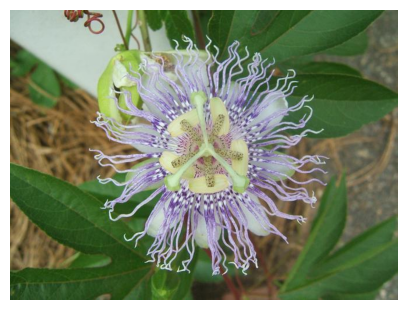

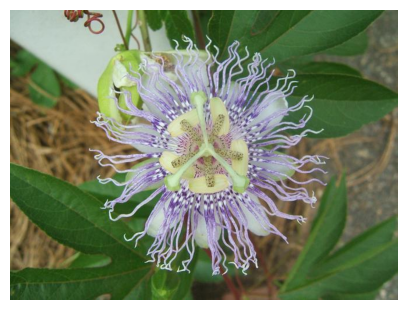

In [97]:
idx = 2

img, label = robust_dataset[idx]

#Plot the retrieved image, which should be the one following corrupted one.
helper.plot_img(img)

#Next image to verify
next_img, next_label = robust_dataset[idx +1]

#Plot the next image
helper.plot_img(next_img)

In [98]:
#Set the grayscale image
idx = 4

#Reconstruct the path. to the original image file
original_img_path = os.path.join(robust_dataset.img_dir, f"image_{idx + 1:05d}.jpg")

#Open the original image directly to check it;s mode before correction
original_img = Image.open(original_img_path)

print(f"Mode of the original image file: {original_img.mode}")

Mode of the original image file: L


Mode of the corrected image: RGB


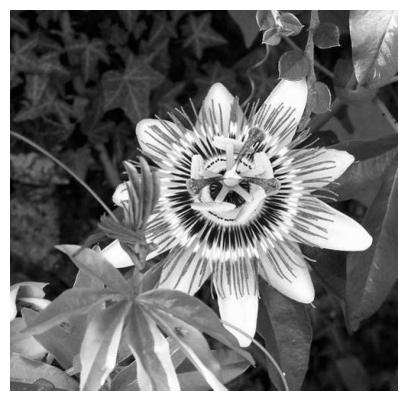

In [100]:
#Retrive the image;the robutst loader should automatically convert it to RGB
img, label = robust_dataset[idx]

#Plot the image to visually confirm
helper.plot_img(img)

print(f"Mode of the corrected image: {img.mode}")

ValueError: setting an array element with a sequence. The requested array has an inhomogeneous shape after 1 dimensions. The detected shape was (2,) + inhomogeneous part.

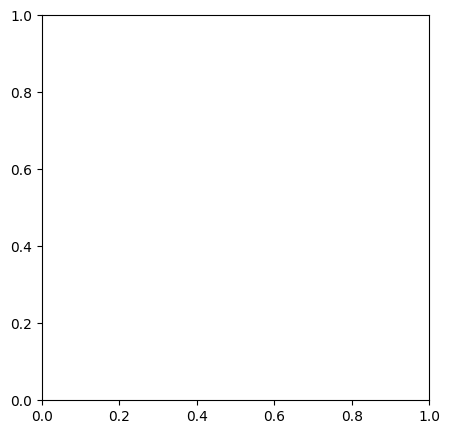

In [101]:
#Set the index to a corrupted iamge

idx = 6

robutst_img = robust_dataset[idx]
helper.plot_img(robutst_img)

next_img, next_label = robust_dataset[idx+1]
helper.plot_img(next_img)

In [102]:
#Display the summary of any corrupted or problematic images found during loading
robust_dataset.get_error_summary()

Encountered 2 problematic images
Index 2: Image too small: (20, 20)
Index 6: cannot identify image file './corrupted_flower_data/jpg/image_00007.jpg'


### Tracking Errors

In real-world deep learning projects, data pipelines need to be robust not only to corrupted files but also to subtle issues that can silently degrade model performance.
Beyond handling exceptions, it’s important to systematically track and analyze the errors and anomalies that occur during data loading and preprocessing.

This final section introduces practical strategies for error tracking within your dataset pipeline.
You’ll learn how to log problematic samples, monitor which images are accessed (and how often), and review error summaries after training.
These techniques help ensure that your pipeline is resilient, transparent, and production-ready, allowing you to detect and resolve data quality issues before they affect your model’s results.

The `MonitoredDataset` class extends `RobustFlowerDataset` to add monitoring features for dataset access and loading performance.

- **Access Tracking**: Each time an image is loaded through `__getitem__`, the class increments a counter for that image index in `self.access_counts`. This allows you to track how often each sample is accessed during training or evaluation.

- **Load Time Measurement**: This class records the time taken to load each image and stores these values in `self.load_times`. If loading an image takes longer than 1 second, a warning is printed with the image index and load time. This helps identify slow-loading samples that may affect training performance.

- **Statistics Reporting**: The `print_stats()` method provides a summary of dataset usage, including:
    - Total number of images in the dataset
    - Number of unique images accessed
    - Number of errors encountered (inherited from the parent class)
    - Average and maximum image load times
    - A warning if any images were never accessed, with examples

These monitoring capabilities help you spot bottlenecks, diagnose errors, and ensure the reliability of your data pipeline—making it easier to debug and optimize dataset handling in deep learning workflows.

The MonitoredDataset class extends RobustFlowerDataset to add monitoring features for dataset access and loading performance.

In [ ]:
class MonitoredDataset(RobustFlowerDataset):
    """
    Extends a robust dataset class to add performance monitoring.

    This class tracks metrics such as how frequently each image is accessed,
    how long each access takes, and which images are never loaded. It provides
    a summary of these statistics to help diagnose data pipeline issues.
    """

    def __init__(self, *args, **kwargs):
        """
        Initializes the monitored dataset object.

        Args:
            *args: Variable length argument list passed to the parent class.
            **kwargs: Arbitrary keyword arguments passed to the parent class.
        """

        #Initialize the parent class with all provided arguments.
        super().__init__(*args, **kwargs)

        #Initializa a dictionary to count how many times each index is accessed
        self.access_counts = {}
        #Initialize a list to store the load time for each access
        self.load_time = []

    def __getitem(self, idx):
        """
        Retrieves a sample while monitoring access counts and load times.

        Args:
            idx (int): The index of the sample to retrieve.

        Returns:
            tuple: The data sample (e.g., image and label) from the parent class.
        """

        import time
        #Record the start time of the operation
        start_time = time.time()
        #Increament the access count for the given index
        self.access_counts[idx] = self.access_counts.get(idx, 0) + 1
        #Call the parent class method to laod the data
        result = super().__getitem__(idx)

        #Calculate the total time taken to load the sample
        load_time = time.time() - start_time

        self.load_time.append(load_time)

        #Check if the load time exceed a certain threashold
        if load_time > 1.0:
            print(f"Slow load: Image {idx} took {load_time: .2f}s")

        return result
    
    def print_stats(self):
        """
        Prints a summary of the dataset's access statistics and performance.
        """
         
        print("==Pipeline statistics===")
        print(f"Total images: {len(self)}")
        print(f"Unique iamges accessed: {len(self.access_counts)}")
        print(f"Error encountered: {len(self.error_log)}")

        #Check if load time has been recorded
        if self.load_time:
            #Calculate the avergar load time
            avg_time = sum(self.load_time) / len(self.load_time)
            max_time = max(self.load_time)
            print(f"Average laod time: {avg_time*1000:.1f} ms")
            print(f"Slowest laod time: {max_time*1000:.1f} ms")

        #Create a set of all. possible indices in the dataset
        all_indices = set(range(len(self)))
        # Create a set of all indices that were actually accessed.
        accessed_indices = set(self.access_counts.keys())
        # Find the set of indices that were never accessed.
        never_accessed = all_indices - accessed_indices
        # Check if there are any images that were never loaded.
        if never_accessed:
            # Print a warning message with the count of never-accessed images.
            print(f"\n⚠️ WARNING: {len(never_accessed)} images were never loaded!")
            # Show a few examples of the indices that were never accessed.
            print(f"   Examples: {list(never_accessed)[:5]}")

In [105]:
#Initialize the monitored dataset with the path to the potentially corrupted data 
monitored_dataset = MonitoredDataset(corrupted_dataset_path)

#Iterate through the dataset to trigger monitoring
for idx in range(len(monitored_dataset)):
    img, label = monitored_dataset[idx]

In [106]:
#print the statistics
monitored_dataset.print_stats()

==Pipeline statistics===
Total images: 10
Unique iamges accessed: 0


AttributeError: 'MonitoredDataset' object has no attribute 'error_logs'